In [1]:
import os
import pandas as pd
import vtk
import re
import numpy as np
from pathlib import Path
from vtk.util import numpy_support
from vtkmodules.vtkIOGeometry import (
    vtkBYUReader,
    vtkOBJReader,
    vtkSTLReader
)
from vtkmodules.vtkIOLegacy import vtkPolyDataReader
from vtkmodules.vtkIOPLY import vtkPLYReader
from vtkmodules.vtkIOXML import vtkXMLPolyDataReader
import matplotlib.pyplot as plt
import seaborn as sns

def ReadPolyData(file_name):
    valid_suffixes = ['.g', '.obj', '.stl', '.ply', '.vtk', '.vtp']
    path = Path(file_name)
    if path.suffix:
        ext = path.suffix.lower()
    if path.suffix not in valid_suffixes:
        print(f'No reader for this file suffix: {ext}')
        return None
    else:
        if ext == ".ply":
            reader = vtkPLYReader()
            reader.SetFileName(file_name)
            reader.Update()
            poly_data = reader.GetOutput()
        elif ext == ".vtp":
            reader = vtkXMLPolyDataReader()
            reader.SetFileName(file_name)
            reader.Update()
            poly_data = reader.GetOutput()
        elif ext == ".obj":
            reader = vtkOBJReader()
            reader.SetFileName(file_name)
            reader.Update()
            poly_data = reader.GetOutput()
        elif ext == ".stl":
            reader = vtkSTLReader()
            reader.SetFileName(file_name)
            reader.Update()
            poly_data = reader.GetOutput()
        elif ext == ".vtk":
            reader = vtkPolyDataReader()
            reader.SetFileName(file_name)
            reader.Update()
            poly_data = reader.GetOutput()
        elif ext == ".g":
            reader = vtkBYUReader()
            reader.SetGeometryFileName(file_name)
            reader.Update()
            poly_data = reader.GetOutput()

        return poly_data

In [4]:
whichpcs = [2,7]

expfold = 'E:/Aaron/random_lls/random/'
shapefold = f'PC{whichpcs[0]}-PC{whichpcs[1]}_Cycle_AllSHCoeff_Visualization/Random/'
cycleshapes = [x for x in os.listdir(expfold + shapefold) if '.vtp' in x]
cycleshapes.sort(key=lambda x: float(re.findall('(?<=frame_)\d*', x)[0]))

lens = []
coordlist = []
for c in cycleshapes:
    mesh = ReadPolyData(expfold+shapefold+c)
    #get cell major, minor, and mini axes using the segmented image
    cell_coords = numpy_support.vtk_to_numpy(mesh.GetPoints().GetData())
    centroid = cell_coords.mean(axis=0, keepdims=True)
    cell_coords -= centroid
    ##### get centroid, largest, and smallest x coordinates
    coordlist.append([cell_coords.mean(axis=0, keepdims=True)[0],
                       cell_coords[cell_coords[:,0] == np.max(cell_coords[:,0])][0],
                       cell_coords[cell_coords[:,0] == np.min(cell_coords[:,0])][0]])
    #Get physical properties of both cell and nucleus
    lens.append(np.max(cell_coords[:,0]) - np.min(cell_coords[:,0]))
#make numpy array from centroid, front, and back coords
larr = np.array(coordlist)
#get the scaling for the speed based on ~22um length along trajectory and ~0.25 um/sec speed
spscale = np.mean(lens)/22 * 0.25

In [5]:

#displacements based on approximate average speed and volume scaling
displacements = np.array(range(len(larr)))*spscale

########### moving the back
blarr = larr.copy()
for i,l in enumerate(blarr):
    #start by aligning the back at 0
    blarr[i,:,0] = l[:,0] - l[-1,0]
    #then add displacement to each
    blarr[i,:,0] = blarr[i,:,0] + displacements[i]

    
############ moving the centroid
clarr = larr.copy()
# #start with centroid at 0 at time zero
# clarr[:,:,0] = clarr[:,:,0] - clarr[0,0,0]
for i,l in enumerate(clarr):
    clarr[i,:,0] = l[:,0] + displacements[i] - l[0,0]

    
############ moving the front
flarr = larr.copy()
for i,l in enumerate(flarr):
    flarr[i,:,0] = l[:,0] + displacements[i] - l[1,0]


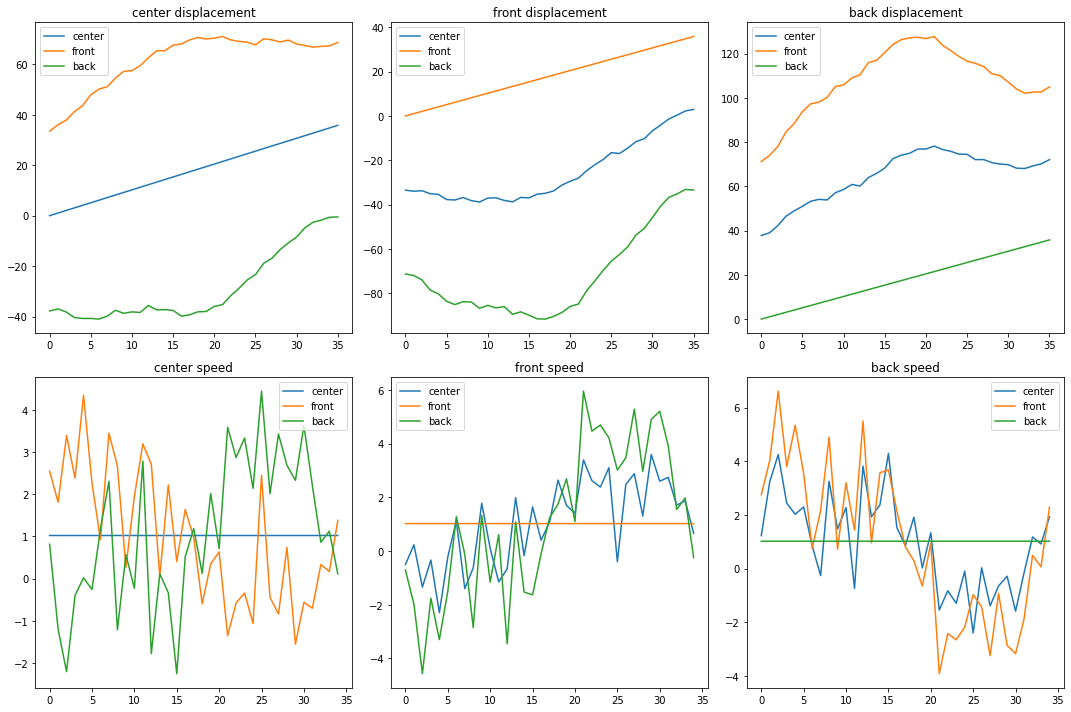

In [6]:
#plot back movement

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
label = ['center','front','back']
for i, l in enumerate([clarr, flarr, blarr]): 
    for j, y in enumerate(l[:,:,0].T):
        sns.lineplot(x = list(range(len(y))), y = y, ax = axes[0,i], label = label[j])
        axes[0,i].set_title(f'{label[i]} displacement')
        #also plot speeds
        sns.lineplot(x = list(range(len(y)-1)), y = np.diff(y), ax = axes[1,i], label = label[j])
        axes[1,i].set_title(f'{label[i]} speed')
        
plt.tight_layout()

In [7]:
################# alternative models

#back stopping
bsdis = displacements.copy()
bsdis[20:] = bsdis[20]
########### moving the back
bslarr = larr.copy()
for i,l in enumerate(bslarr):
    #start by aligning the back at 0
    bslarr[i,:,0] = l[:,0] - l[-1,0]
    #then add displacement to each
    bslarr[i,:,0] = bslarr[i,:,0] + bsdis[i]
    
#back relaxing constantly
bsdis = displacements.copy()
bsdis[20:] = bsdis[20]
########### moving the back
bslarr = larr.copy()
for i,l in enumerate(bslarr):
    #start by aligning the back at 0
    bslarr[i,:,0] = l[:,0] - l[-1,0]
    #then add displacement to each
    bslarr[i,:,0] = bslarr[i,:,0] + bsdis[i]

#center moving "accurately"
prodis = np.arange(np.mean(lens)/22 * 0.19, np.mean(lens)/22 * 0.29, ((np.mean(lens)/22 * 0.29)- (np.mean(lens)/22 * 0.19))/21)
redis = np.arange(np.mean(lens)/22 * 0.29, np.mean(lens)/22 * 0.19, ((np.mean(lens)/22 * 0.19)- (np.mean(lens)/22 * 0.29))/15)
adis = np.cumsum(np.concatenate((prodis,redis)))
############ moving the centroid
aclarr = larr.copy()
# #start with centroid at 0 at time zero
# clarr[:,:,0] = clarr[:,:,0] - clarr[0,0,0]
for i,l in enumerate(aclarr):
    aclarr[i,:,0] = l[:,0] + adis[i] - l[0,0]
    
########### moving the back
blarr = larr.copy()
for i,l in enumerate(blarr):
    #start by aligning the back at 0
    blarr[i,:,0] = l[:,0] - l[-1,0]
    #then add displacement to each
    blarr[i,:,0] = blarr[i,:,0] + adis[i]
    
############ moving the front
flarr = larr.copy()
for i,l in enumerate(flarr):
    flarr[i,:,0] = l[:,0] + adis[i] - l[1,0]


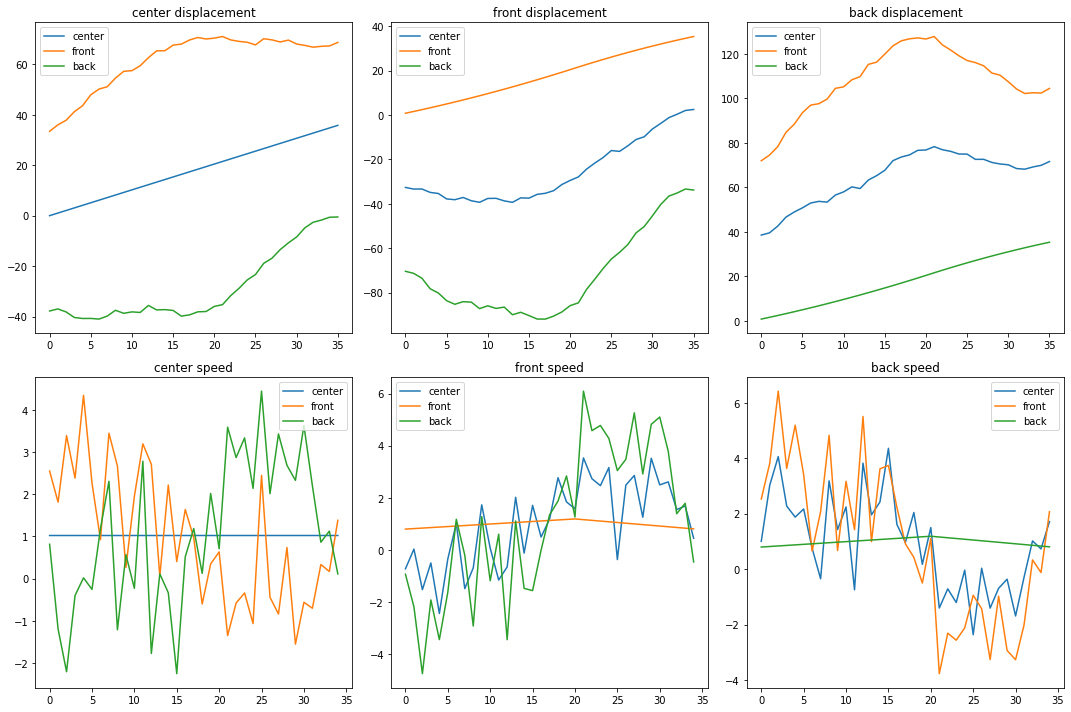

In [8]:
##### PLOT THE "ACCURATE" SPEED 
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
label = ['center','front','back']
for i, l in enumerate([clarr, flarr, blarr]): 
    for j, y in enumerate(l[:,:,0].T):
        sns.lineplot(x = list(range(len(y))), y = y, ax = axes[0,i], label = label[j])
        axes[0,i].set_title(f'{label[i]} displacement')
        #also plot speeds
        sns.lineplot(x = list(range(len(y)-1)), y = np.diff(y), ax = axes[1,i], label = label[j])
        axes[1,i].set_title(f'{label[i]} speed')
        
plt.tight_layout()

In [ ]:
########## center movement shows initial front protrusion (front moving faster than cell),
########## then retraction (rear moving faster than cell)

########## front movement shows

In [19]:
blarr

array([[[ 3.49047241e+01,  3.21793407e-01,  5.91555178e-01],
        [ 7.12108307e+01,  1.32413793e+00, -1.15673566e+00],
        [ 0.00000000e+00,  4.55399990e+00, -1.71612358e+00]],

       [[ 3.33506317e+01,  4.94576842e-01, -3.24398339e-01],
        [ 7.29437561e+01,  1.50998604e+00, -2.43816710e+00],
        [ 0.00000000e+00,  4.57388592e+00, -8.59801352e-01]],

       [[ 3.51250191e+01,  6.92238986e-01, -5.59561431e-01],
        [ 7.59457855e+01,  1.17379351e+01, -1.25133014e+00],
        [ 0.00000000e+00, -2.24729776e+00, -1.95455313e+00]],

       [[ 3.95721016e+01,  3.77862155e-01, -2.41670802e-01],
        [ 8.15345001e+01, -4.59989786e+00, -2.50609875e+00],
        [ 0.00000000e+00,  5.24115896e+00, -1.06367350e+00]],

       [[ 4.16178131e+01,  8.30205977e-01, -6.93902493e-01],
        [ 8.43126373e+01,  4.60077524e+00, -3.12349010e+00],
        [ 0.00000000e+00, -1.23574913e+00, -2.48010755e+00]],

       [[ 4.20518494e+01, -1.72517508e-01,  3.77478749e-01],
        [ 8.86

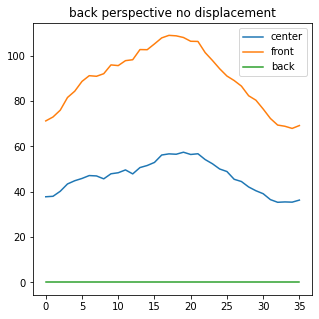

In [9]:
########## BACK MOVEMENT BUT SUBTRACT DISPLACEMENT
########### moving the back
blarr = larr.copy()
for i,l in enumerate(blarr):
    #start by aligning the back at 0
    blarr[i,:,0] = l[:,0] - l[-1,0]
    #then add displacement to each
    blarr[i,:,0] = blarr[i,:,0]

fig, ax = plt.subplots(1,1, figsize=(5, 5))
label = ['center','front','back']
for j, y in enumerate(blarr[:,:,0].T):
    sns.lineplot(x = list(range(len(y))), y = y, ax = ax, label = label[j])
    ax.set_title(f'back perspective no displacement')
plt.savefig('E:/Aaron/random_lls/random/back perspective no displacement.png')